# Tutorial 4: Interconnection and multinodal networks

## Introduction

This tutorial demonstrates how to create and analyze multi-nodal power systems using PyPSA. We'll explore how to model interconnected power systems and understand the role of network elements in power system analysis. We'll also see how complex interconnected systems can be simplified while maintaining their essential characteristics.

In [66]:
from pypsa import Network
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook", style="white")
plt.rc("axes.spines", top=False, right=False)

# Load the timeseries data
ts = pd.read_csv("data/timeseries.csv", index_col=0, parse_dates=True)
costs = pd.read_csv("data/costs.csv", index_col=0)
e_price = pd.read_csv("data/electricity_prices_interconnector_DE.csv")
e_price.index = ts.index
e_price.columns = ['DE']

# Set the same tech limits as before
tech_limits = {
    "wind": 150e3,
    "solar": 300e3,
}

## Creating a two-bus system

Let's create a system with two buses: one representing a load center and another representing a generation center with a biogas plant.

In [96]:
# Initialize network
n = Network()
n.set_snapshots(ts.index)

n.add("Carrier", "electricity")

# Add buses
n.add("Bus", "load_bus", carrier="electricity")
n.add("Bus", "generation_bus", carrier="electricity")

# Add load to the load bus
n.add(
    "Load",
    "demand",
    bus="load_bus",
    p_set=ts.load,
)

# Add renewable generators to the load bus (from previous tutorial)
for tech in ["wind", "solar"]:
    n.add(
        "Generator",
        tech,
        bus="load_bus",
        p_max_pu=ts[tech],
        capital_cost=costs.at[tech, "capital_cost"],
        marginal_cost=costs.at[tech, "marginal_cost"],
        p_nom_extendable=True,
        p_nom_max=tech_limits[tech],
    )

# add battery storage
EP_RATIO = 6
n.add(
    "StorageUnit",
    "battery storage",
    bus="load_bus",
    max_hours=EP_RATIO,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + EP_RATIO * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

# add long-duration flow battery
FLOW_EP_RATIO = 100
n.add(
    "StorageUnit",
    "flow battery",
    bus="load_bus",
    max_hours=FLOW_EP_RATIO,
    capital_cost=costs.at["flow battery power", "capital_cost"]
    + FLOW_EP_RATIO * costs.at["flow battery energy", "capital_cost"],
    efficiency_store=costs.at["flow battery power", "efficiency"],
    efficiency_dispatch=costs.at["flow battery power", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

# Add biogas generator to the generation bus
n.add(
    "Generator",
    "biogas ccgt",
    bus="generation_bus",
    capital_cost=costs.at["biogas ccgt", "capital_cost"],
    marginal_cost=costs.at["biogas ccgt", "marginal_cost"],
    p_nom=12000,  # 12 GW capacity
    p_nom_extendable=False,
)

# Add network element connecting the buses
n.add(
    "Link",
    "transmission_line",
    bus0="generation_bus",
    bus1="load_bus",
    p_nom=12000,  # 12 GW capacity
    efficiency=0.95,  # 5% losses in transmission
)

Index(['transmission_line'], dtype='object')

## Analyzing the Two-Bus System

Let's optimize this system and analyze its behavior.

In [97]:
# Optimize the system
n.optimize(solver_name="highs")


/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 45.07it/s]
INFO:linopy.io: Writing time: 1.07s


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+02]
  Cost   [5e-01, 3e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+04, 3e+05]
Presolving model
91953 rows, 74437 cols, 258339 nonzeros  0s
91953 rows, 74437 cols, 258339 nonzeros  0s
Presolve : Reductions: rows 91953(-118293); columns 74437(-13167); elements 258339(-131460)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.83545e+08) 0s
      11648     1.6622832313e+08 Pr: 14971(1.95233e+10); Du: 0(2.17698e-07) 6s
      17164     1.6707098152e+08 Pr: 17346(6.09031e+10); Du: 0(3.46264e-07) 11s
      21666     1.6805543082e+08 Pr: 19312(1.09839e+11); Du: 0(3.2474e-07) 17s
      23141     1.6843453855e+08 Pr: 19941(1.35336e+11); Du: 0(3.84239e-07) 22s
      26632     1.6934636616e+08 Pr: 21479(1.72579e+11); Du: 0(4.61331e-07) 28s
      29513     3.2

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 210246 duals
Objective: 1.18e+09
Solver model: available
Solver message: optimal



Relative P-D gap    :  1.4143650119e-15
HiGHS run time      :         81.39
Writing the solution to /tmp/linopy-solve-s8z6ous7.sol


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

### Visualisation


Text(0.5, 0, '')

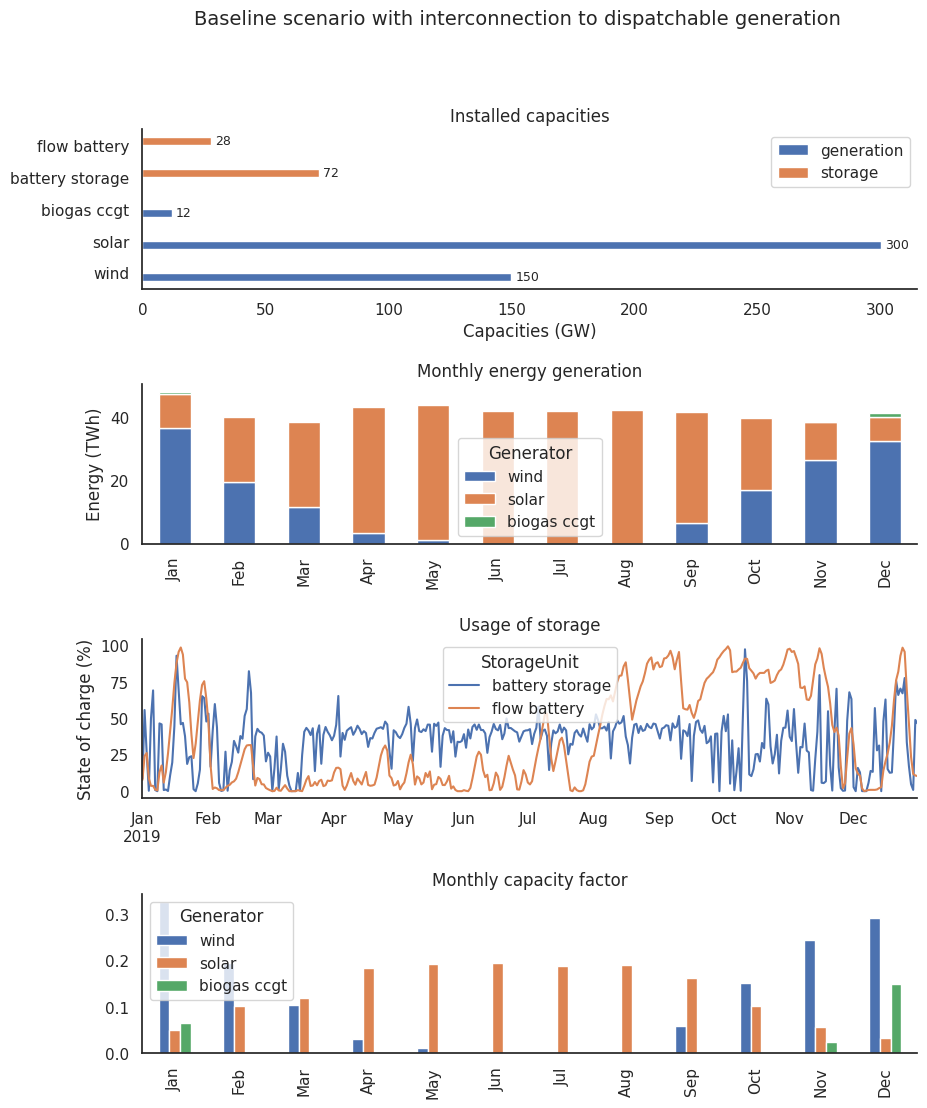

In [ ]:
# Plot the monthly energy balance

fig, axes = plt.subplots(4, 1, figsize=(10, 14))
plt.subplots_adjust(hspace=0.6)

### 1 -- Energy balance
ax = axes[0]
capacity_data = pd.concat(
    [
        n.generators.p_nom_opt,
        n.storage_units.p_nom_opt,
    ],
    axis=1,
).div(1e3)

capacity_data.columns = ["generation", "storage"]

capacity_data.plot(kind="barh", ax=ax)
ax.set_title("Installed capacities (GW)")
ax.set_xlabel("")

for container in ax.containers:
    # Get the labels only for non-zero values
    labels = [f"{v:.0f}" if v != 0 else "" for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type="edge", fontsize=9, padding=3)


### 2 -- Energy balance

ax = axes[1]

generation = n.generators_t.p.resample("ME").sum().div(1e6)

generation.index = generation.index.strftime("%b")
generation.plot(
    kind="bar", ax=ax, legend=True, stacked=True
)

ax.set_title("Monthly energy generation")
ax.set_ylabel("Energy (TWh)")
ax.set_xlabel("")


### 3 -- State of charge
ax = axes[2]

state_of_charge = n.storage_units_t.state_of_charge / (
    n.storage_units.max_hours * n.storage_units.p_nom_opt
)
state_of_charge.index = n.snapshots
state_of_charge = state_of_charge.resample("D").mean().mul(100)

state_of_charge.plot(
    kind="line", ax=ax, legend=True, title="Usage of storage"
)


ax.set_ylabel("State of charge (%)")
ax.set_xlabel("")


fig.suptitle(
    "Baseline scenario with interconnection to dispatchable generation", fontsize=14
)

### 4 -- Capacity factors
ax = axes[3]

combined_cf = n.generators_t.p.resample("ME").mean() / n.generators.p_nom_opt
combined_cf.index = combined_cf.index.strftime("%b")

combined_cf.plot(
    ax=ax, kind="bar", title="Monthly capacity factor", legend=True, position=0.5
)
ax.set_xlabel("")

### Analysis
- Renewable capacity remains important: 300 GW solar, 150 GW wind  
  *(at the upper limit still)*
- Storage mix: 72 GW short-duration batteries, 28 GW long-duration flow batteries  
  *(a significant reduction in long-duration flow batteries from 50 GW)*
- Clear seasonal generation patterns:
    - Wind peaks in winter (Dec-Feb)
    - Solar peaks in summer (May-Aug)
    - Biogas provides winter backup
- Distinct storage behavior:
    - Batteries: Regular daily cycling year-round
    - Flow batteries: Deep seasonal charging/discharging patterns

The multinodal network analysis reveals a renewable-dominated system with strategic deployment of storage and dispatchable generation. The large renewable capacities (450 GW total) form the backbone of generation, while the storage portfolio combines short-duration batteries for daily balancing with long-duration flow batteries for seasonal energy shifting. The biogas CCGT, though limited in capacity, provides crucial winter backup when renewable generation is lower.

Storage operation shows clear technological specialization: batteries handle daily variations while flow batteries manage seasonal imbalances, particularly storing summer solar surplus for winter use. This complementary storage strategy, combined with the seasonal patterns of wind and solar generation, enables the system to maintain reliability across all timescales despite the high renewable penetration.

:::{note}
The statement about batteries handling daily variations does not become clear from the state-of-charge because it is averaged out on a daily resolution. We choose to apply this resampling to improve legibility of the more seasonal patterns. When plotting the data at the original resolution, we observe short-cyclic behaviour of the battery storage. Try plotting it yourself! 
:::

## Simple market-based interconnection model

In real power systems, interconnections link to markets with many different power plants and technologies. This is more complex than our previous model that only used a biogas plant on the other side of the connection.
We can simplify this by treating the interconnection as a generator that can buy and sell electricity at market prices. Key aspects of this approach:

Uses real market prices instead of modeling plants
- Treats the connection as a simple import/export generator
- Much simpler than modeling the entire connected market
- Example: using German prices for Dutch-German connection

This simplification works best when:

- The modeled system is small compared to the connected market
- Price changes from our trades would be negligible
- Analysis is at provincial level or smaller
- We don't need to capture detailed market interactions

Main limitations:

- Ignores how our demand affects market prices (merit-order effects)
- Not suitable for large systems like whole countries
- Assumes unlimited availability at market price
- May oversimplify complex market dynamics

Despite these limitations, for regional studies this simplified approach offers a good balance between accuracy and model complexity.

:::{note}
In our case study of the Dutch power system, this market-based simplification is not appropriate. The Netherlands represents a significant share of European electricity markets and faces real interconnector constraints. We use this simplified approach purely for educational purposes to demonstrate market coupling concepts.
:::

### Initiating and optimising our network

In [102]:
# Create a new simplified network
n_simple = Network()
n_simple.set_snapshots(ts.index)

# Add single bus
n_simple.add("Bus", "load_bus")

# Add load
n_simple.add(
    "Load",
    "demand",
    bus="load_bus",
    p_set=ts.load,
)

# Add renewable generators
for tech in ["wind", "solar"]:
    n_simple.add(
        "Generator",
        tech,
        bus="load_bus",
        p_max_pu=ts[tech],
        capital_cost=costs.at[tech, "capital_cost"],
        marginal_cost=costs.at[tech, "marginal_cost"],
        p_nom_extendable=True,
        p_nom_max=tech_limits[tech],
    )


# add battery storage
EP_RATIO = 6
n_simple.add(
    "StorageUnit",
    "battery storage",
    bus="load_bus",
    max_hours=EP_RATIO,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + EP_RATIO * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

# add long-duration flow battery
FLOW_EP_RATIO = 100
n_simple.add(
    "StorageUnit",
    "flow battery",
    bus="load_bus",
    max_hours=FLOW_EP_RATIO,
    capital_cost=costs.at["flow battery power", "capital_cost"]
    + FLOW_EP_RATIO * costs.at["flow battery energy", "capital_cost"],
    efficiency_store=costs.at["flow battery power", "efficiency"],
    efficiency_dispatch=costs.at["flow battery power", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)


# Add market connection as a generator with time-varying prices
n_simple.add(
    "Generator",
    "market_connection",
    bus="load_bus",
    marginal_cost=e_price["DE"],  # Time-varying prices
    p_nom=12000,  # Same capacity as transmission line
)

Index(['market_connection'], dtype='object')

In [103]:
# Optimize the simplified system
n_simple.optimize(solver_name="highs")

# make sure we keep both networks available
n_prior = n
n = n_simple

Index(['load_bus'], dtype='object', name='Bus')
Index(['load_bus'], dtype='object', name='Bus')
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 50.75it/s]
INFO:linopy.io: Writing time: 0.87s


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+02]
  Cost   [1e-02, 3e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+04, 3e+05]
Presolving model
91953 rows, 74437 cols, 258339 nonzeros  0s
91953 rows, 74437 cols, 258339 nonzeros  0s
Presolve : Reductions: rows 91953(-92013); columns 74437(-4407); elements 258339(-96420)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(5.36213e+09) 0s
       9568     1.7616023827e+08 Pr: 37300(3.81662e+11); Du: 0(7.22463e-08) 6s
      14946     1.9594038389e+08 Pr: 37959(1.06795e+12); Du: 0(7.22463e-08) 14s
      18936     2.1611406976e+08 Pr: 38719(1.67663e+12); Du: 0(7.91169e-08) 19s
      22175     2.3455814306e+08 Pr: 38921(2.31002e+12); Du: 0(7.22463e-08) 24s
      25535     2.6086450199e+08 Pr: 39174(3.43157e+12); Du: 0(9.19542e-08) 30s
      30630     2.868

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78844 primals, 183966 duals
Objective: 1.14e+09
Solver model: available
Solver message: optimal



Relative P-D gap    :  5.6713132417e-15
HiGHS run time      :         88.91
Writing the solution to /tmp/linopy-solve-nw6lp8i_.sol


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


## Analyzing the simple market-based interconnection model

### Visualisation

Text(0.5, 0, '')

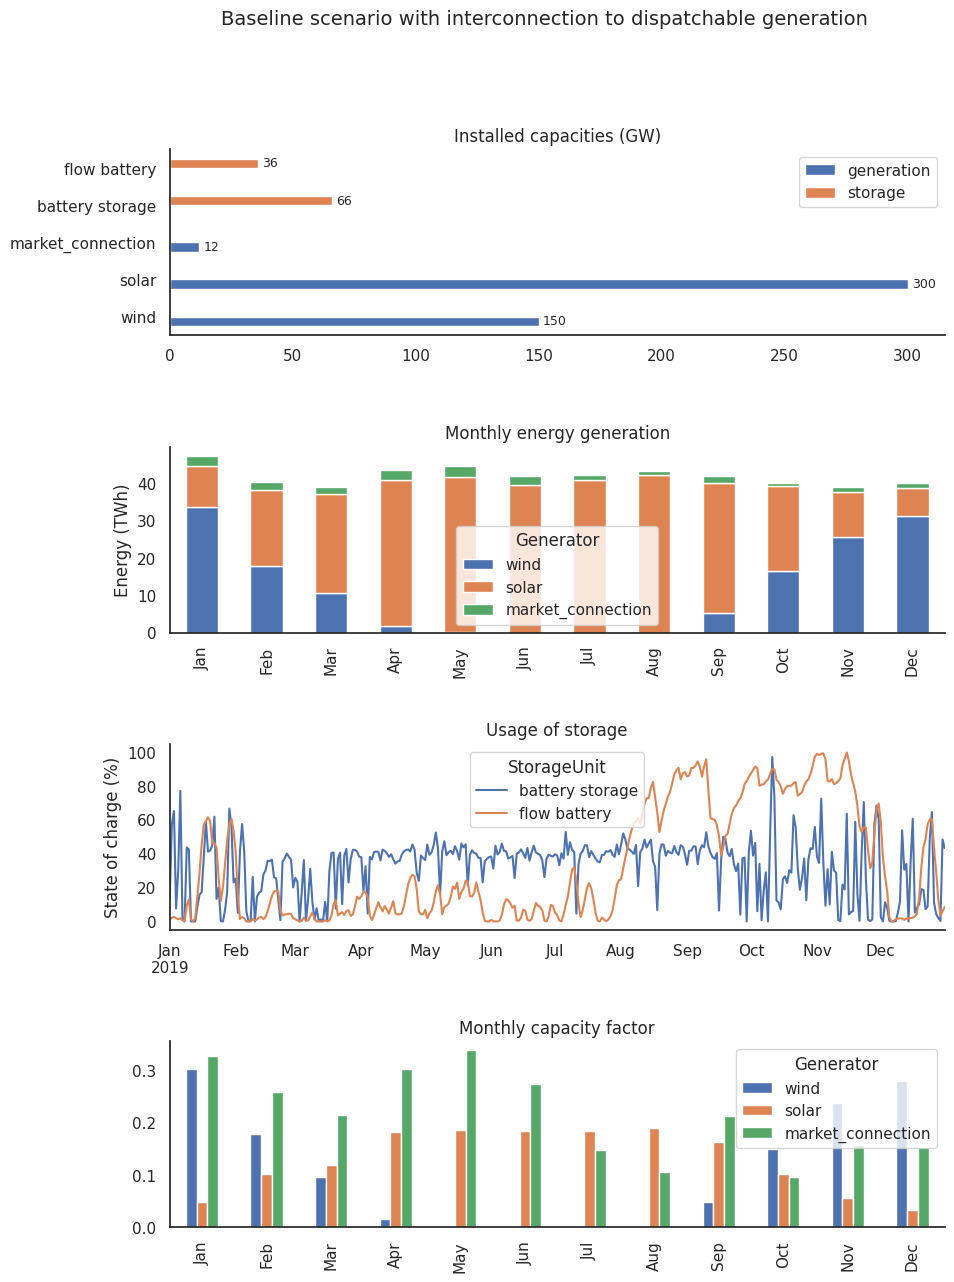

In [104]:
# Plot the monthly energy balance

fig, axes = plt.subplots(4, 1, figsize=(10, 14))
plt.subplots_adjust(hspace=0.6)

### 1 -- Energy balance
ax = axes[0]
capacity_data = pd.concat(
    [
        n.generators.p_nom_opt,
        n.storage_units.p_nom_opt,
    ],
    axis=1,
).div(1e3)

capacity_data.columns = ["generation", "storage"]

capacity_data.plot(kind="barh", ax=ax)
ax.set_title("Installed capacities (GW)")
ax.set_xlabel("")

for container in ax.containers:
    # Get the labels only for non-zero values
    labels = [f"{v:.0f}" if v != 0 else "" for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type="edge", fontsize=9, padding=3)


### 2 -- Energy balance

ax = axes[1]

generation = n.generators_t.p.resample("ME").sum().div(1e6)

generation.index = generation.index.strftime("%b")
generation.plot(
    kind="bar", ax=ax, legend=True, stacked=True
)

ax.set_title("Monthly energy generation")
ax.set_ylabel("Energy (TWh)")
ax.set_xlabel("")


### 3 -- State of charge
ax = axes[2]

state_of_charge = n.storage_units_t.state_of_charge / (
    n.storage_units.max_hours * n.storage_units.p_nom_opt
)
state_of_charge.index = n.snapshots
state_of_charge = state_of_charge.resample("D").mean().mul(100)

state_of_charge.plot(
    kind="line", ax=ax, legend=True, title="Usage of storage"
)


ax.set_ylabel("State of charge (%)")
ax.set_xlabel("")


fig.suptitle(
    "Baseline scenario with interconnection to dispatchable generation", fontsize=14
)

### 4 -- Capacity factors
ax = axes[3]

combined_cf = n.generators_t.p.resample("ME").mean() / n.generators.p_nom_opt
combined_cf.index = combined_cf.index.strftime("%b")

combined_cf.plot(
    ax=ax, kind="bar", title="Monthly capacity factor", legend=True, position=0.5
)
ax.set_xlabel("")

### Analysis

- Storage slightly changes: battery storage from 72 GW to 66 GW, flow battery from 28 GW to 36 GW
- Renewable capacities remain at upper limit: 300 GW solar and 150 GW wind
- Both models use 12 GW interconnection capacity
- Market connection shows very high utilization (capacity factors), remarkably especially in summer months

The market-based model demonstrates more flexible operation compared to the biogas CCGT scenario. While both models maintain the same renewable and interconnection capacities, the market connection's dynamic pricing enables more frequent utilization throughout the year, as shown by higher capacity factors. This is particularly evident in summer months, where the market connection actively trades power while the biogas CCGT was barely used.

The shift in storage capacities (less short-term, more long-term storage) suggests that market-based trading provides better short-term flexibility than the biogas plant, reducing the need for battery storage. However, the increase in flow battery capacity indicates a greater need for seasonal storage to take advantage of market price variations throughout the year. This shows how access to market-based trading can influence the optimal mix of system flexibility options.

### Understanding the simplification

This simplification represents how the Dutch power system is connected to the broader European electricity market:

1. The transmission line capacity (12 GW) represents the Netherlands' total interconnection capacity with neighboring countries.
2. The time-varying prices represent the German electricity market prices, which influence when the Netherlands imports or exports electricity.
3. When local renewable generation is cheaper than the market price, the system will use local generation.
4. When the market price is lower than local generation costs, the system will import power through the "market connection".

This simplified model captures the essential economic behavior of the interconnected system while being computationally more efficient. The key insights are:

- The Netherlands is not an isolated system but part of an integrated European electricity market
- Market prices in neighboring countries significantly influence local dispatch decisions
- Interconnection capacity constraints can limit the ability to import/export power
- Local renewable generation competes with import options based on relative costs



## Conclusion

We've learned how to:
1. Create a multi-nodal power system with interconnections
2. Add dispatchable generation (biogas) to the system
3. Model transmission constraints between nodes
4. Simplify complex interconnected systems while maintaining their essential characteristics
5. Understand how the Netherlands' power system interacts with the European electricity market

This understanding is crucial for energy system planning, as it helps balance the development of local generation capacity with interconnection capabilities.